### Predicting Creditworthiness: A Model for Evaluating Customer Payment Reliability 


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,roc_curve

Carregamos os conjuntos de dados de treinamento/teste

In [21]:
df_train = pd.read_csv("conjunto_de_treinamento.csv")     
df_test = pd.read_csv("conjunto_de_teste.csv")

train=df_train.copy()
test=df_test.copy()

train=train.set_index('id_solicitante')
test=test.set_index('id_solicitante')

Lidamos com dados ausentes:

- Eles são removidos se forem raros o suficiente 
- Caso contrário, são substituídos por um valor específico (por exemplo, média, mediana, 0) 

In [22]:
print('Is Na:\n',train.isna().sum()[train.isna().sum()>0])
print('number of grau_instrucao not null =',train['grau_instrucao'].loc[train['grau_instrucao']!=0].size)

Is Na:
 tipo_residencia                 536
meses_na_residencia            1450
profissao                      3097
ocupacao                       2978
profissao_companheiro         11514
grau_instrucao_companheiro    12860
dtype: int64
number of grau_instrucao not null = 0


In [23]:
train['sexo'].fillna('N', inplace=True)
test['sexo'].fillna('N', inplace=True)


train.drop(columns=['profissao_companheiro', 
                          'grau_instrucao_companheiro',
                          'grau_instrucao'],inplace=True)


test.drop(columns=['profissao_companheiro', 
                          'grau_instrucao_companheiro',
                          'grau_instrucao'],inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_17620\1000971493.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['sexo'].fillna('N', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17620\1000971493.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

Podemos ver que há muitos valores ausentes para as categorias profissao_companheiro e grau_instrucao_companheiro, portanto, sugiro não usá-las como categorias em meu modelo

    train.drop(columns=['profissao_companheiro', 'grau_instrucao_companheiro'], inplace=True)

como vou usar o XGBoost, que lida corretamente com valores ausentes, não preciso fazer isso 

Para as categorias tipo_residencia, meses_na_residencia, profissao e ocupacao, sempre poderíamos deixar o XGBoost, mas proponho processar esses valores usando a imputação do modelo KNN.

In [24]:
from sklearn.impute import KNNImputer

columns_to_impute = ['tipo_residencia', 'meses_na_residencia', 'profissao', 'ocupacao']
imputer = KNNImputer(n_neighbors=5)
train[columns_to_impute] = imputer.fit_transform(train[columns_to_impute])

In [25]:
train.isnull().sum()[train.isnull().sum()>0]


Series([], dtype: int64)

A coluna 'possui_telefone_celular' contém apenas “N”, portanto, vamos eliminá-la 

In [26]:
train.drop(columns=['possui_telefone_celular'],inplace=True)

### Visualização da Dependência Intuitiva entre Características

Nossa intuição nos indica que algumas características podem ter uma relação de causalidade muito forte com a variável alvo.

Podemos considerar, por exemplo, algumas características que acredito estarem correlacionadas com o fato de ser um mau pagador:

- O salário mensal

In [27]:
df=train.copy()
df=df[['renda_mensal_regular','inadimplente','valor_patrimonio_pessoal']].dropna()
df.describe()

,renda_mensal_regular,inadimplente,valor_patrimonio_pessoal
count,20000.000000,20000.000000,2.000000e+04
mean,957.130937,0.500000,2.095614e+03
std,11353.965001,0.500013,4.403344e+04
min,69.000000,0.000000,0.000000e+00
25%,360.000000,0.000000,0.000000e+00
50%,500.000000,0.500000,0.000000e+00
75%,800.000000,1.000000,0.000000e+00
max,959000.000000,1.000000,6.000000e+06


Podemos olhar um histograma para ver a proporção de bons e maus pagadores distribuídos por categoria de renda mensal.

C:\Users\user\AppData\Local\Temp\ipykernel_17620\475520164.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['categorie_revenu', 'inadimplente']).size().unstack()


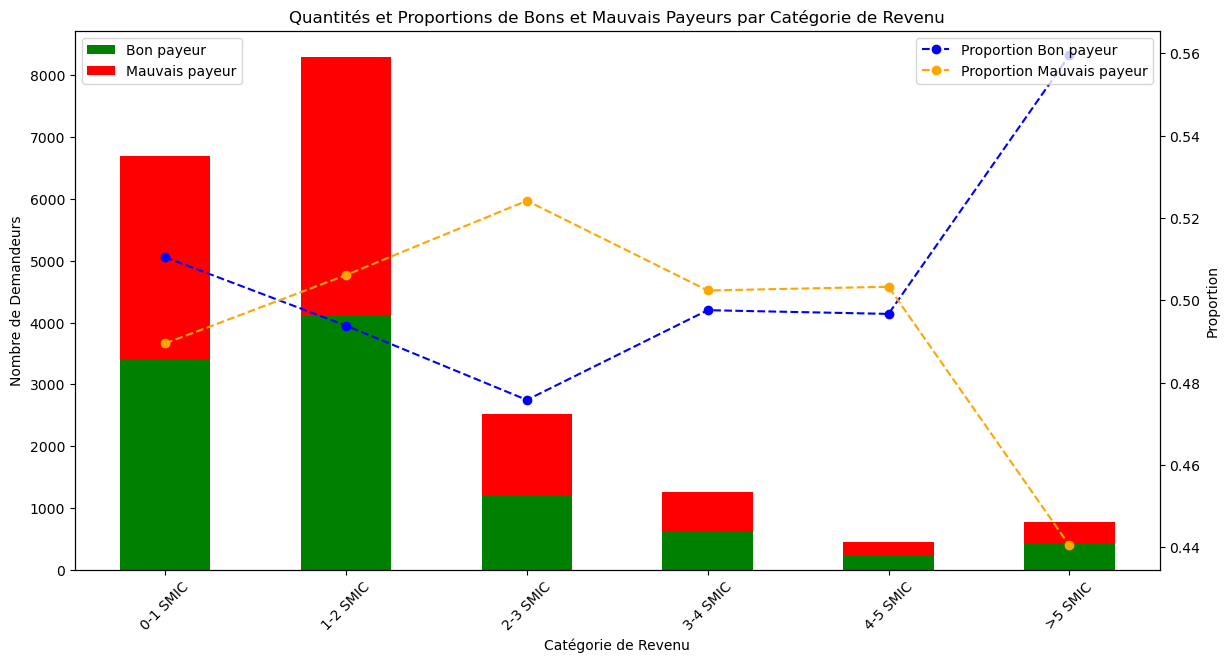

In [28]:
smic_bresilien = 400
# Créer des catégories de revenus basées sur le SMIC brésilien
bins = [0, smic_bresilien, 2*smic_bresilien, 3*smic_bresilien, 4*smic_bresilien, 5*smic_bresilien, float('inf')]
labels = ['0-1 SMIC', '1-2 SMIC', '2-3 SMIC', '3-4 SMIC', '4-5 SMIC', '>5 SMIC']

df['categorie_revenu'] = pd.cut(df['renda_mensal_regular'], bins=bins, labels=labels, right=False)

# Calculer les quantités de bons et mauvais payeurs dans chaque catégorie de revenus
counts = df.groupby(['categorie_revenu', 'inadimplente']).size().unstack()
proportions = counts.div(counts.sum(axis=1), axis=0)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Quantités de bons et mauvais payeurs
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=ax1)
ax1.set_xlabel('Catégorie de Revenu')
ax1.set_ylabel('Nombre de Demandeurs')
ax1.legend(['Bon payeur', 'Mauvais payeur'], loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Proportions de bons et mauvais payeurs
ax2 = ax1.twinx()   
proportions.plot(kind='line', marker='o', ax=ax2, color=['blue', 'orange'], linestyle='--')
ax2.set_ylabel('Proportion')
ax2.legend(['Proportion Bon payeur', 'Proportion Mauvais payeur'], loc='upper right')

plt.title('Quantités et Proportions de Bons et Mauvais Payeurs par Catégorie de Revenu')
plt.show()

#### Encodamento dos Conjuntos de Dados

Codificamos os conjuntos de dados, primeiramente para exibir a matriz de correlação e poder determinar as categorias importantes. Em seguida, para ter uma entrada correta no nosso modelo.

In [29]:
def encode_df(df):
    
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in categorical_columns:
        if df[column].nunique()<=2:
            df[column] = LabelBinarizer().fit_transform(df[column])
         

        elif df[column].nunique()>2 and df[column].nunique()<5:
            df = pd.get_dummies(df,columns=[column])

        elif df[column].nunique()>5:
            df[column] = LabelEncoder().fit_transform(df[column])
            df.drop(columns=column, inplace=True)
                    
    return df

In [30]:
train=encode_df(train)
test=encode_df(test)

Exibimos a matriz de correlação para os 15 valores mais correlacionados com nossa variável alvo. Evidentemente, tomamos o valor absoluto dessas correlações, pois uma correlação forte e negativa é tão importante quanto uma positiva.

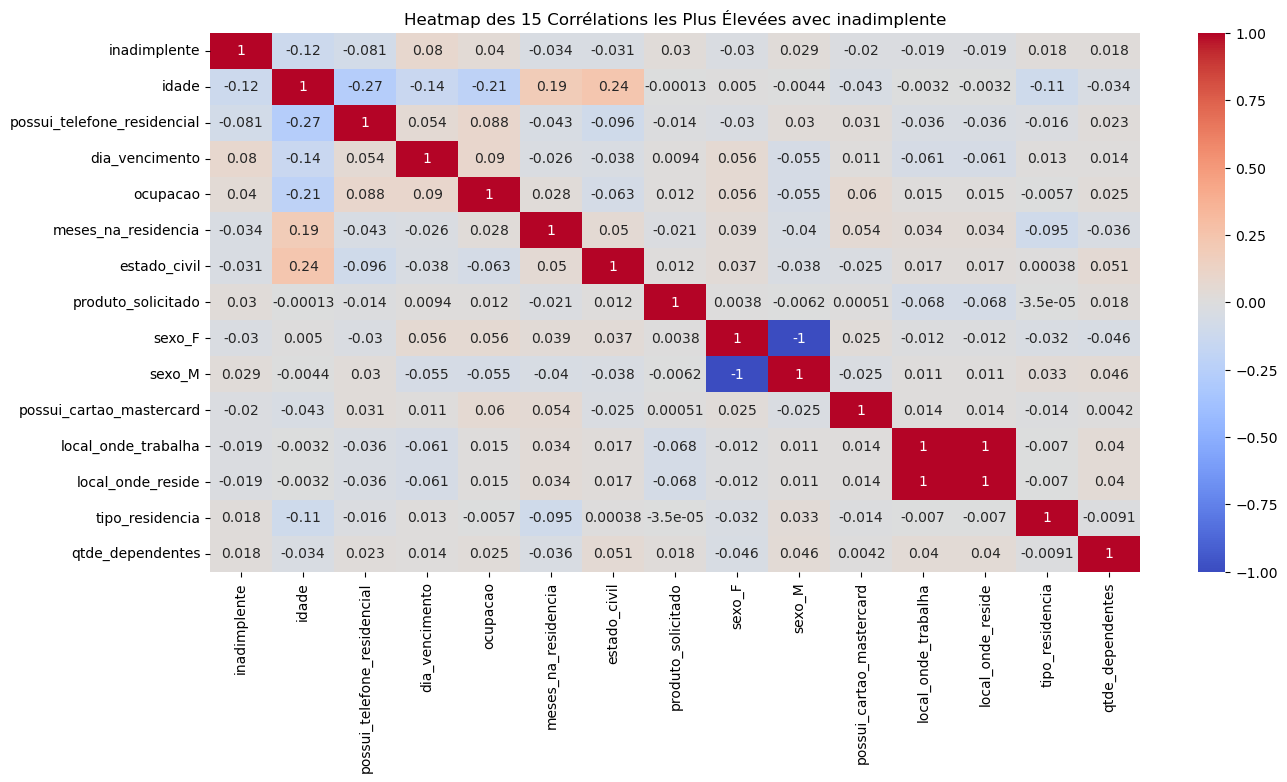

In [31]:
df=train.copy()
correlation = df.corr()

correlation_abs = correlation[['inadimplente']].abs()

correlation_target = correlation_abs[['inadimplente']].sort_values(by='inadimplente', ascending=False)

top_15_columns = correlation_target.head(15).index

cm = train[top_15_columns].corr()


plt.figure(figsize=(15, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=top_15_columns, yticklabels=top_15_columns)
plt.title('Heatmap des 15 Corrélations les Plus Élevées avec inadimplente')
plt.show()

Agora podemos selecionar características com base nas variáveis mais correlacionadas com nossa variável alvo. Mas, mantemos em mente que precisamos evitar a multicolinearidade.

In [35]:
features = [
    'idade',  
    'possui_telefone_residencial',
    'dia_vencimento',
    'ocupacao',
    # 'grau_instrucao_companheiro',
    # 'profissao_companheiro',
    'meses_na_residencia',
    'produto_solicitado' 
]

### Definição e Teste do Nosso Modelo

Aqui vamos escolher os modelos preditivos e construir um script Python para testá-los. 

Também poderemos verificar o desempenho dos modelos preditivos escolhidos por validação cruzada, utilizando o conjunto de treinamento fornecido.

In [36]:
X=train[features]
y=train['inadimplente']



model1 = XGBClassifier()
model2 = lgb.LGBMClassifier()
model3 = RandomForestClassifier()

In [37]:
# quick check if the data is balanced 

y.value_counts()

inadimplente
0    10000
1    10000
Name: count, dtype: int64

## Usando Validação Cruzada Adequada

1) Agrupamento
2) Embaralhamento ativado


GroupKFold é uma boa escolha para esta situação porque temos diferentes tipos de produtos solicitados, que são muito diferentes.

Aqui está como é implementado:

In [38]:
groups=train['produto_solicitado']
gkf = GroupKFold(n_splits=3)
gkf.split(X,y,groups)

<generator object _BaseKFold.split at 0x000001F7806E4660>

In [40]:

model=model1
def groupKFold(X,y,groups,model):
    fold = 0
    accs = []
    for train_idx, val_idx in gkf.split(X, y, groups):
        train_idx
        val_idx
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]
        
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        model1.fit(X_tr, y_tr)
        pred = model1.predict(X_val)
        pred_prob = model1.predict_proba(X_val)[:, 1]
        acc_score = accuracy_score(y_val, pred)
        auc_score = roc_auc_score(y_val, pred_prob)
        print(f"======= Fold {fold} ========")
        print(
            f"Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
        )
        fold += 1
        accs.append(acc_score)
    oof_acc = np.mean(accs)
    print(f'Our out of fold AUC score is {oof_acc:0.4f}')

### Regressão logística multivariada

A regressão logística multivariada não leva em conta os valores de entrada NaN, portanto, eles devem ser removidos. 

In [2]:
train_for_reg=train.dropna()

X_for_reg=train_for_reg[features]
y_for_reg=train_for_reg['inadimplente']
groups_for_reg=train_for_reg['produto_solicitado']


param_dist = {
    'C': [0.1,1,10,100],
    'max_iter':[10000],
    'solver': ['lbfgs','sag','saga'],
    'random_state':[42],
    'class_weight':['balanced']
}


best_model = GridSearchCV(estimator=LogisticRegression(),param_grid=param_dist,
                               cv=gkf.split(X_for_reg, y_for_reg, groups_for_reg),
                               verbose=2, n_jobs=-1)


best_model.fit(X_for_reg, y_for_reg, groups=groups_for_reg)

results=best_model.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Score: {mean_score:.4f} | Paramètres: {params}")

print("\nMeilleur score (accuracy) obtenu :", best_model.best_score_)
print("Paramètres du meilleur modèle :", best_model.best_params_)

NameError: name 'train' is not defined

### Pesquisa dos Melhores Parâmetros do Modelo para RandomForest

Usamos o método RandomizedSearchCV para encontrar os melhores hiperparâmetros para nosso modelo, sempre com a validação cruzada GroupKFold.

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_dist = {
    'n_estimators': [int(x) for x in range(100, 600, 100)],
    'max_depth': [10],
    # 'random_state':[],
}


best_model = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_dist,
                               cv=gkf.split(X, y, groups),
                               verbose=2, n_jobs=-1)


best_model.fit(X, y, groups=groups)

results=best_model.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Score: {mean_score:.4f} | Paramètres: {params}")

print("\nMeilleur score (accuracy) obtenu :", best_model.best_score_)
print("Paramètres du meilleur modèle :", best_model.best_params_)

### Utilização de CatBoost
Para melhorar as performances

In [50]:
from catboost import CatBoostClassifier

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)

Método Iterativo para Encontrar os Melhores Hiperparâmetros

In [42]:
results = []
for iterations in range(20, 220, 20):
  for depth in range(2, 14, 2):
    clfCB = CatBoostClassifier(depth=depth, iterations=iterations, learning_rate=0.1, verbose=False)
    pred = clfCB.fit(X_train, y_train).predict(X_val)
    results.append((iterations, depth, accuracy_score(y_val,pred)))
    print(iterations, depth, accuracy_score(y_val,pred))

best_choose = sorted(results, key=lambda i: i[-1])
print (best_choose[-1])

20 2 0.5885
20 4 0.58975
20 6 0.59425
20 8 0.58925
20 10 0.59175
20 12 0.58675
40 2 0.59175
40 4 0.58875
40 6 0.593
40 8 0.5905
40 10 0.5905
40 12 0.5885
60 2 0.5915
60 4 0.58725
60 6 0.58875
60 8 0.5885
60 10 0.58575
60 12 0.58225
80 2 0.5885
80 4 0.58825
80 6 0.5885
80 8 0.58875
80 10 0.58175
80 12 0.57975
100 2 0.5885
100 4 0.58425
100 6 0.5865
100 8 0.58625
100 10 0.57875
100 12 0.5775
120 2 0.5875
120 4 0.584
120 6 0.588
120 8 0.58425
120 10 0.58075
120 12 0.57625
140 2 0.58725
140 4 0.58625
140 6 0.585
140 8 0.584
140 10 0.5805
140 12 0.577
160 2 0.58725
160 4 0.58525
160 6 0.586
160 8 0.584
160 10 0.57725
160 12 0.573
180 2 0.58875
180 4 0.58875
180 6 0.58575
180 8 0.58
180 10 0.578
180 12 0.57275
200 2 0.5815
200 4 0.5875
200 6 0.58175
200 8 0.57475
200 10 0.57
200 12 0.57125
(20, 6, 0.59425)


In [82]:
results = []
iter=0
# for lr in np.arange(0.11995,0.120,0.00001):
for lr in np.arange(0.005,0.2,0.01):
    iter+=1
    clfCB = CatBoostClassifier(depth=6, iterations=20, learning_rate=lr, verbose=False)
    pred = clfCB.fit(X_train, y_train).predict(X_val)
    results.append((lr, accuracy_score(y_val,pred)))
    print(iter, lr, accuracy_score(y_val,pred))

best_choose = sorted(results, key=lambda i: i[-1])
print (best_choose[-1])

1 0.005 0.585
2 0.015 0.5835
3 0.024999999999999998 0.5805
4 0.034999999999999996 0.584
5 0.04499999999999999 0.5835
6 0.054999999999999986 0.583
7 0.06499999999999999 0.584
8 0.075 0.58325
9 0.08499999999999999 0.58175
10 0.09499999999999999 0.58225
11 0.10499999999999998 0.5815
12 0.11499999999999999 0.58
13 0.12499999999999999 0.58325
14 0.13499999999999998 0.58275
15 0.145 0.57675
16 0.15499999999999997 0.58475
17 0.16499999999999998 0.57925
18 0.175 0.5845
19 0.18499999999999997 0.57975
20 0.19499999999999998 0.5815
(0.005, 0.585)


In [83]:
best_lr=best_choose[-1][0]
clf=CatBoostClassifier(depth=6,iterations=20,learning_rate=best_lr,verbose=False)
clf.fit(X_train,y_train)

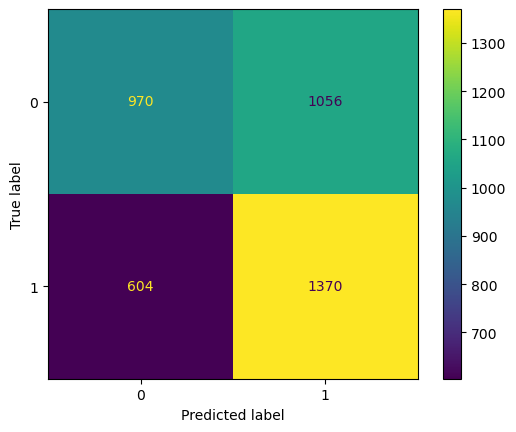

In [84]:
y_pred=clf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

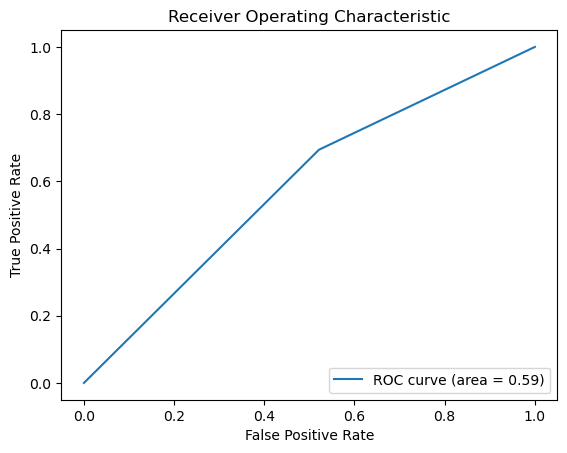

In [85]:
fpr, tpr, _ = roc_curve(y_val, y_pred)  # y_prob are the predicted probabilities
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_pred))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Modelo Final
Finalmente, realizamos a previsão com o melhor modelo.

In [ ]:
clf=CatBoostClassifier(depth=8,iterations=160,learning_rate=0.1199,verbose=False)
clf.fit(X,y)
X_test=test.loc[:,test.columns != 'inadimplente']

In [ ]:
y_pred_=clf.predict(X_test)

Formatamos as previsões e as armazenamos em um arquivo CSV.

In [ ]:
predictions = pd.DataFrame(test.index, columns=['id_solicitante'])
predictions['inadimplente']=y_pred
predictions=predictions.set_index('id_solicitante')
predictions

,inadimplente
id_solicitante,
20001,0
20002,1
20003,1
20004,1
20005,0
...,...
24996,0
24997,1
24998,1


In [ ]:
predictions.to_csv('predictions.csv')